In [1]:
from osgeo import gdal
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import read_cover_fraction as rcf
import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely import geometry
from mpl_toolkits.basemap import Basemap

# Declare functions

## function to read the data

In [2]:
def get_dataSG(fname,latmax,latmin,lonmax,lonmin):

    gdal.UseExceptions()
    ds = gdal.Open(fname)
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    #
    #
    #
    xres = gt[1]
    yres = gt[5]
    #
    xmin = gt[0]
    ymin = gt[3]
    #
    xmax = gt[0] + (xres * ds.RasterXSize)
    ymax = gt[3] + (yres * ds.RasterYSize)
#    else:
#        xmax = gt[0] + (xres * ds.RasterXSize) 
#        ymax = gt[3] + (yres * ds.RasterYSize) 


    X=np.arange(xmin+xres,xmax+xres,xres)
    Y=np.arange(ymin+yres,ymax+yres,yres)


    #Chunck the data to save RAM for plotting
    #Ydecreasing
    b=np.min(np.where(Y<latmin)[0])
    a=np.max(np.where(Y>latmax)[0])

    c=np.max(np.where(X<lonmin)[0])
    d=np.min(np.where(X>lonmax)[0])

#    print(np.max(data))
#    print(np.min(data))
    #ECOCLIMAP data have no projections so no need to reproject the data
    #to be verified for other datasets
    LAT=Y[a:b]
    LON=X[c:d]
    D=data[a:b,c:d]

    return (LAT,LON,D)

## Read station coordinates function

In [3]:
def readstationcoordinate(fnstation):
    data=open(fnstation,'r')
    lat=[]
    lon=[]
    for d in data:
        lat.append(d.split(' ')[0].strip(' '))
        lon.append(d.split(' ')[1].strip(' '))
    LAT=np.array(lat).astype(float)
    LON=np.array(lon).astype(float)
    return(LAT,LON)

## Function to set correspondance between station and line in the csv files

In [4]:
def set_covernumber_station(LAT,LON,LATSG,LONSG,covernum,DSG):
    Linenum=[]
    for x,_ in enumerate(LAT):
        idx=np.argmin(np.abs(LAT[x]-LATSG))
        idy=np.argmin(np.abs(LON[x]-LONSG))
        Linenum.append(np.where(covernum==int(DSG[idx,idy]))[0][0])
    return (Linenum)

## Write cover station text file

In [5]:
def write_txt_file_cover_station(fntxt,LAT,LON,Linenum,covernum,covername,cityfrac,vegfrac,inwaterfrac,seafrac):
    data=open(fntxt,'w')
    data.write('LAT, LON, Covernum, Covername, City fraction, Vegetation fraction, Inland water fraction, sea fraction\n')
    for x,_ in enumerate(LAT):
        data.write(str(LAT[x])+', '+str(LON[x])+', '+str(covernum[Linenum[x]])+', '+covername[Linenum[x]]+', '+
                   str(cityfrac[Linenum[x]])+', '+str(vegfrac[Linenum[x]])+', '+
                   str(inwaterfrac[Linenum[x]])+', '+str(seafrac[Linenum[x]])+'\n')
    data.close()
    return

## Function to extract the Surfex data

In [6]:
def surfex_fractions (fnforc,fn,Variablelist):
    FORC=xr.open_dataset(fnforc)
    OUT=xr.open_dataset(fn)
    x_shape=int(OUT['IMAX'].values.mean())
    y_shape=int(OUT['JMAX'].values.mean())
    Pn=OUT.PATCH.Number_of_Patches
    df=pd.DataFrame()
    df['Geometry']=[geometry.Point(x, y) for x, y in zip(FORC['LAT'], FORC['LON'])]
    gdf=gpd.GeoDataFrame(df,geometry='Geometry', crs= 'EPSG:4326')
    LEG=[]
    LEG.append('Geometry')
    for Variable in Variablelist:
        if len(OUT[Variable].shape)==3:
            for P in Pn: 
                LEG.append(OUT[Variable].comment)
                vname=Variable+'Pa'+str(int(np.mean(P.values))+1)
                gdf[vname]=OUT[Variable][int(np.mean(P.values))].to_dataframe(name=vname).values
        else:
            gdf[Variable]=OUT[Variable].to_dataframe(name=Variable).values
            LEG.append(OUT[Variable].comment)
    return (x_shape,y_shape,gdf,LEG)

## Get lat/lon for plotting

In [7]:
def getlatlon1d(gdf,x_shape,y_shape):
    gdf['LONGITUDE']=[d.y for d in gdf.geometry]
    gdf['LATITUDE']=[d.x for d in gdf.geometry]
    LON=gdf.LONGITUDE.values.reshape(x_shape,y_shape)
    LAT=gdf.LATITUDE.values.reshape(x_shape,y_shape)
    LAT1d=LAT[0,:]
    LON1d=LON[:,0]
    return (LON1d,LAT1d)

## Plot surfex data

In [34]:
def surfex_plot_ecosg_eco2(fnforc,fneco2,fnSG,Variableslist='Z0',colormap='gist_ncar_r',VMIN=0,VMAX=1,
                          latc=53.2,lonc=-8.2,extent=5.6,stationno='00'):
    if type(Variableslist)!=list:
        Variableslist=[Variableslist]
    (x_shape,y_shape,gdfeco2,LEGeco2)=surfex_fractions(fnforc,fneco2,Variableslist)
    (x_shape,y_shape,gdfSG,LEGSG)=surfex_fractions(fnforc,fnSG,Variableslist)
    (LON1d2,LAT1d2)=getlatlon1d(gdfeco2,x_shape,y_shape)
    (LON1dsg,LAT1dsg)=getlatlon1d(gdfSG,x_shape,y_shape)
    if type(latc)!=list:
        latc=[latc]
        lonc=[lonc]
        stationno=[stationno]
    for j,_ in enumerate(latc):
        latmin=latc[j]-extent/2.0
        latmax=latc[j]+extent/2.0
        lonmin=lonc[j]-extent/2.0
        lonmax=lonc[j]+extent/2.0
        for i,vname in enumerate(gdfeco2.columns):
            if 'Geometry' not in vname:
                if 'LONGITUDE' not in vname:
                    if 'LATITUDE' not in vname:
                        fig,axes=plt.subplots(1,2,figsize=(2*15,15))
                        ax1=axes[0]
                        m = Basemap(llcrnrlon=lonmin,
                        llcrnrlat=latmin,
                        urcrnrlon=lonmax,
                        urcrnrlat=latmax,
                        lat_0=(latmax-latmin)/2,
                        lon_0=(lonmax-lonmin)/2,
                        projection='merc',
                        resolution = 'h',
                        area_thresh=10000.,
                        ax=ax1)
                        m.drawcoastlines()
                        m.drawcountries()
                        LONg, LATg = np.meshgrid(LON1dsg, LAT1dsg)
                        lons, lats = m(LONg, LATg)
                        c=m.pcolormesh(lons,lats,gdfSG[vname].values.reshape(x_shape,y_shape),cmap=colormap,vmin=VMIN,vmax=VMAX)
                        #m.ax.set_xlabel('Longitude',fontsize=20)
                        #m.ax.set_ylabel('Latitude',fontsize=20)
                        m.ax.xaxis.set_tick_params(labelsize=20)
                        m.ax.yaxis.set_tick_params(labelsize=20)
                        m.ax.set_xlim(lonmin,lonmax)
                        m.ax.set_ylim(latmin,latmax)
                        m.ax.set_title(vname+' ECOCLIMAPSG',fontsize=20)
                        ax2=axes[1]
                        m = Basemap(llcrnrlon=lonmin,
                        llcrnrlat=latmin,
                        urcrnrlon=lonmax,
                        urcrnrlat=latmax,
                        lat_0=(latmax-latmin)/2,
                        lon_0=(lonmax-lonmin)/2,
                        projection='merc',
                        resolution = 'h',
                        area_thresh=10000.,
                        ax=ax2)
                        m.drawcoastlines()
                        m.drawcountries()
                        LONg, LATg = np.meshgrid(LON1d2, LAT1d2)
                        lons, lats = m(LONg, LATg)
                        c=m.pcolormesh(lons,lats,gdfeco2[vname].values.reshape(x_shape,y_shape),cmap=colormap,vmin=VMIN,vmax=VMAX)
                        #m.ax.set_xlabel('Longitude',fontsize=20)
                        #m.ax.set_ylabel('Latitude',fontsize=20)
                        m.ax.xaxis.set_tick_params(labelsize=20)
                        m.ax.yaxis.set_tick_params(labelsize=20)
                        m.ax.set_xlim(lonmin,lonmax)
                        m.ax.set_ylim(latmin,latmax)
                        m.ax.set_title(vname+' ECOCLIMAP2',fontsize=20)
                        cbar_ax = fig.add_axes([0.91, 0.10, 0.03, 0.8])
                        cb=fig.colorbar(c, cax=cbar_ax) 
                        cb.set_label(LEGeco2[i],fontsize=20)
                        cb.ax.tick_params(labelsize=20)
                        fig.savefig(vname+'latc'+str(latc[j])+'lonc'+str(lonc[j])+'sta'+str(stationno[j])+'surfex.png')
                        plt.close(fig)
    return

In [95]:
def plot_ecosg_eco2_fraction(fractionsg,LONsg,LATsg,fractionII,LONII,LATII,colormap='gist_ncar_r',VMIN=0,VMAX=1,
                          latc=53.2,lonc=-8.2,extent=5.6,stationno='00',LEG='Fraction',vname='Fraction',res = 'h',background=1,fill='white'):
#function to plot ecoclimap2 and ecococlimap SG fractions in its native resolution
#fractionsg fraction data ecoclimap sg
#LONsg.LATsg longitude latitude ecoclimap SG
#fractionII fraction data ecoclimap 2
#LONII,LATII latitude longitude ecoclimap2 
#VMIN colorbar min
#VMAX colorbar max
#vname variable name for filename save
#LEG colorbar legend char
#latc,lonc longitude latitude center of the plot
#extent extent of the plot
# stationno station num or name for filesave
    if type(latc)!=list:
        latc=[latc]
        lonc=[lonc]
        stationno=[stationno]
    for j,_ in enumerate(latc):
        latmin=latc[j]-extent/2.0
        latmax=latc[j]+extent/2.0
        lonmin=lonc[j]-extent/2.0
        lonmax=lonc[j]+extent/2.0
        fig, axes = plt.subplots(1, 2,figsize=(2*15, 15))
        ax1=axes[0]
        m = Basemap(llcrnrlon=lonmin,
        llcrnrlat=latmin,
        urcrnrlon=lonmax,
        urcrnrlat=latmax,
        lat_0=(latmax-latmin)/2,
        lon_0=(lonmax-lonmin)/2,
        projection= 'tmerc',
        resolution = res,
        area_thresh=10000.,
        ax=ax1)
        LONg, LATg = np.meshgrid(LONsg, LATsg)
        lons, lats = m(LONg, LATg)
        c=m.pcolormesh(lons,lats,fractionsg,cmap=colormap, vmin=VMIN,vmax=VMAX)
        #m.ax.set_xlabel('Longitude',fontsize=20)
        #m.ax.set_ylabel('Latitude',fontsize=20)
        m.ax.xaxis.set_tick_params(labelsize=30)
        m.ax.yaxis.set_tick_params(labelsize=30)
        LONMIN,LATMIN=m(lonmin,latmin)
        LONMAX,LATMAX=m(lonmax,latmax)
        m.ax.set_xlim(LONMIN,LONMAX)
        m.ax.set_ylim(LATMIN,LATMAX)
        m.drawmapboundary(color='k',linewidth=1.0,fill_color=fill)
        m.drawcountries()
        m.drawcoastlines()
        m.drawparallels(np.arange(latmin,latmax,1),labels=[1,1,0,1], fontsize=30)
        m.drawmeridians(np.arange(lonmin,lonmax,1),labels=[1,1,0,1], rotation=45, fontsize=30)
        m.ax.set_title(vname+' ECOCLIMAP-SG',fontsize=30)
        ax2=axes[1]
        m = Basemap(llcrnrlon=lonmin,
        llcrnrlat=latmin,
        urcrnrlon=lonmax,
        urcrnrlat=latmax,
        lat_0=(latmax-latmin)/2,
        lon_0=(lonmax-lonmin)/2,
        projection='tmerc',
        resolution = res,
        area_thresh=10000.,
        ax=ax2)
        LONg, LATg = np.meshgrid(LONII, LATII)
        lons, lats = m(LONg, LATg)
        c=m.pcolormesh(lons,lats,fractionII,cmap=colormap,vmin=VMIN,vmax=VMAX)
        #m.ax.set_xlabel('Longitude',fontsize=20)
        #m.ax.set_ylabel('Latitude',fontsize=20)
        m.ax.xaxis.set_tick_params(labelsize=30)
        m.ax.yaxis.set_tick_params(labelsize=30)
        m.drawmapboundary(color='k',linewidth=1.0,fill_color=fill)
        m.drawcoastlines()
        m.drawstates()
        m.drawcountries()
        m.drawparallels(np.arange(latmin,latmax,1),labels=[1,1,0,1], fontsize=30)
        m.drawmeridians(np.arange(lonmin,lonmax,1),labels=[1,1,0,1], rotation=45, fontsize=30)
        LONMIN,LATMIN=m(lonmin,latmin)
        LONMAX,LATMAX=m(lonmax,latmax)
        m.ax.set_xlim(LONMIN,LONMAX)
        m.ax.set_ylim(LATMIN,LATMAX)
        m.ax.set_title(vname+' ECOCLIMAP2.2',fontsize=30)
        cbar_ax = fig.add_axes([0.93, 0.10, 0.009, 0.8])
        cb=fig.colorbar(c, cax=cbar_ax) 
        cb.set_label(LEG,fontsize=30)
        cb.ax.tick_params(labelsize=30)
        fig.savefig(vname+'latc'+str(latc[j])+'lonc'+str(lonc[j])+'sta'+str(stationno[j])+'native.png')
        #plt.close(fig)
    return

# MAIN 

## Airport station coordinate

In [10]:
#Cork airport
corklat=51.842
corklon=-8.485
#Dublin airport
dubalat=53.423 
dubalon=-6.238
#Knock airport
Knlat=53.906
Knlon=-8.817
#Shannon airport
Shlat=52.687
Shlon=-8.917
# Sligo airport
Sllat=54.274
Sllon=-8.592
LAT=[corklat,dubalat,Knlat,Shlat,Sllat]
LON=[corklon,dubalon,Knlon,Shlon,Sllat]
AIRPORT=['Cork','Dublin','Knock','Shannon','Sligo']

## Weather Station coordinate

In [11]:
station_file='/mnt/g/Station_list_no.txt'
obsdata = open(station_file,'r')
L=[o.split(' ') for o in obsdata.readlines()][0]
Stno=[str(l.split(',')[0]) for l in L]
Stlat=[float(l.split(',')[1])/10000.0 for l in L]
Stlon=[float(l.split(',')[2])/-10000.0 for l in L]

## Open ECOCLIMAP-SG data

In [12]:
latmax=56
latmin=50.4
lonmax=-5.4
lonmin=-11

fnameSG='/mnt/g/ECOCLIMAP/ECOCLIMAPSG/ecosg_final_map.dir'
(LATSG,LONSG,DSG)=get_dataSG(fnameSG,latmax,latmin,lonmax,lonmin)
covernamef='/mnt/g/ECOCLIMAP/ECOCLIMAPSG/ECOCLIMAP_SG_cover_data.csv'
#get the cover deatils from the csvfile
(fieldnames,covernum,covername,cityfrac,vegfrac,inwaterfrac,seafrac)=rcf.cover_fraction(covernamef)
#create fraction array 
TownfracSG=rcf.convert_to_cover_fraction(DSG,cityfrac)
VegfracSG=rcf.convert_to_cover_fraction(DSG,vegfrac)
InwfracSG=rcf.convert_to_cover_fraction(DSG,inwaterfrac)
SeafracSG=rcf.convert_to_cover_fraction(DSG,seafrac)

## Open ECOCLIMAP II data

In [77]:
latmax=55.5
latmin=50.9
lonmax=-5.4
lonmin=-11

fnameII='/mnt/g/ECOCLIMAP/open_ECOCLIMAP2.3/ECOCLIMAP_II_EUROP_V2.3.dir'
(LATII,LONII,DII)=get_dataSG(fnameII,latmax,latmin,lonmax,lonmin)
filenamecoverII='/mnt/g/ECOCLIMAP/ECOCLIMAP_II_cover_data.csv'
(fieldnamesII,covernumII,covernameII,cityfracII,vegfracII,inwaterfracII,seafracII)=rcf.cover_fraction(filenamecoverII)
#create fraction array 
TownfracII=rcf.convert_to_cover_fraction(DII,cityfracII)
VegfracII=rcf.convert_to_cover_fraction(DII,vegfracII)
InwfracII=rcf.convert_to_cover_fraction(DII,inwaterfracII)
SeafracII=rcf.convert_to_cover_fraction(DII,seafracII)

## Open and plot offline-surfex data

KeyboardInterrupt: 

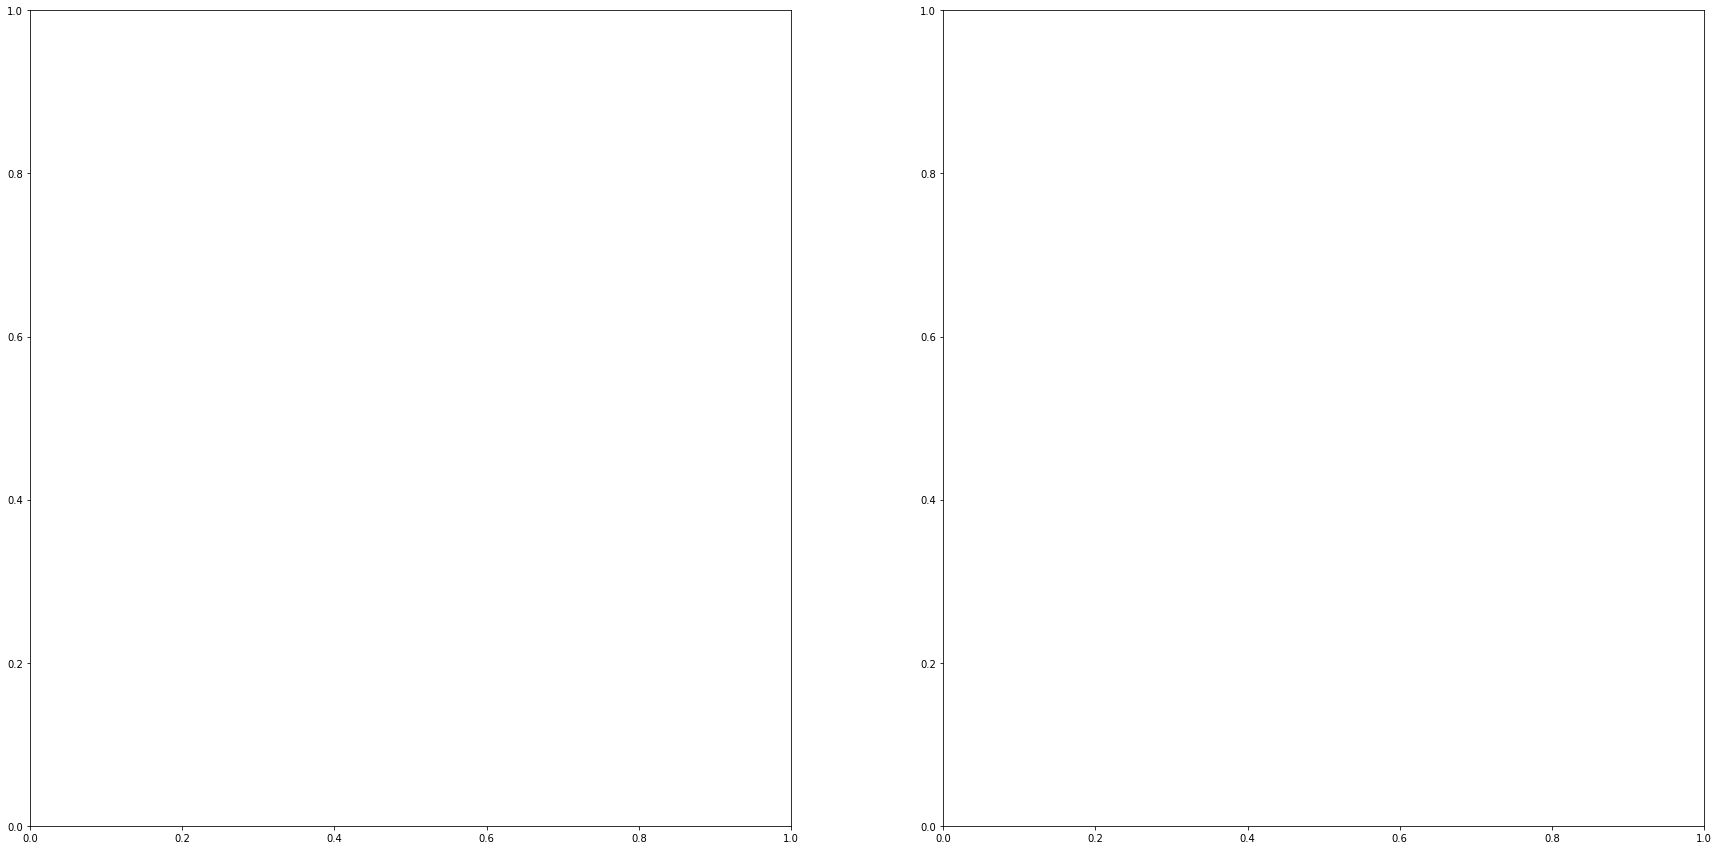

In [17]:
Variableslist=['FRAC_SEA','FRAC_NATURE','FRAC_WATER','FRAC_TOWN','PATCH']
Z0list=['Z0','Z0_ISBA']
fnforc='/mnt/g/offline_surfex_MERA/FORCING.nc'
fnSG='/home/geoffreybess/SURFEX/open_SURFEX_V8_1/MY_RUN/Eire/SURFOUT.20180618_07h00.nc'
fneco2='/home/geoffreybess/SURFEX/open_SURFEX_V8_1/MY_RUN/Eireeco2/SURFOUT.20180618_07h00.nc'
surfex_plot_ecosg_eco2(fnforc,fneco2,fnSG,Variableslist)
surfex_plot_ecosg_eco2(fnforc,fneco2,fnSG,Variableslist,latc=LAT,lonc=LON,extent=0.05,stationno=AIRPORT)
surfex_plot_ecosg_eco2(fnforc,fneco2,fnSG,Variableslist,latc=Stlat,lonc=Stlon,extent=0.05,stationno=Stno)
surfex_plot_ecosg_eco2(fnforc,fneco2,fnSG,Z0list)
surfex_plot_ecosg_eco2(fnforc,fneco2,fnSG,Z0list,latc=LAT,lonc=LON,extent=0.05,stationno=AIRPORT,VMIN=0,VMAX=0.5)
surfex_plot_ecosg_eco2(fnforc,fneco2,fnSG,Z0list,latc=Stlat,lonc=Stlon,extent=0.05,stationno=Stno,VMIN=0,VMAX=0.5)

In [ ]:
Z0TEB=['Z0_TEB']
surfex_plot_ecosg_eco2(fnforc,fneco2,fnSG,Z0TEB)
surfex_plot_ecosg_eco2(fnforc,fneco2,fnSG,Z0TEB,latc=LAT,lonc=LON,extent=0.05,stationno=AIRPORT,VMIN=0,VMAX=2)
surfex_plot_ecosg_eco2(fnforc,fneco2,fnSG,Z0TEB,latc=Stlat,lonc=Stlon,extent=0.05,stationno=Stno,VMIN=0,VMAX=2)
m.dr

## Plot fraction cover

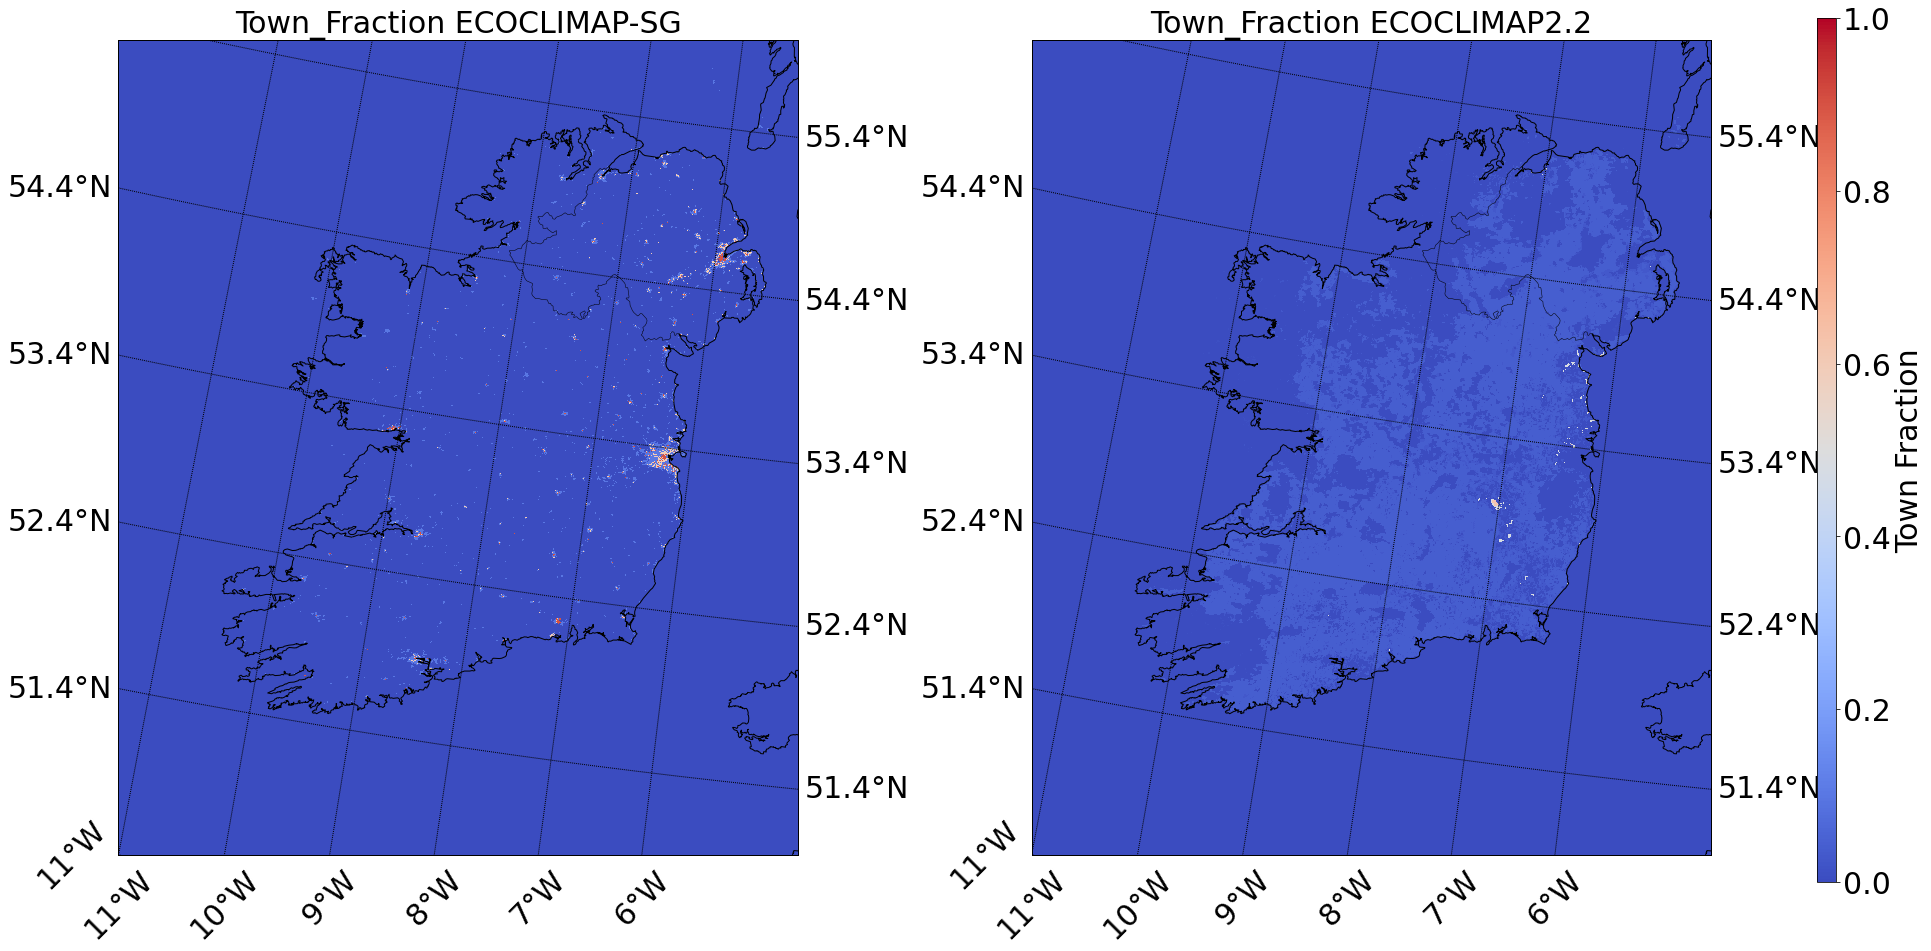

In [96]:
cmap = plt.cm.get_cmap('coolwarm')
rgba = cmap(0)
#Nationwide
plot_ecosg_eco2_fraction(TownfracSG,LONSG,LATSG,TownfracII,LONII,LATII,colormap='coolwarm',LEG='Town Fraction',vname='Town_Fraction',res='h',fill=rgba)

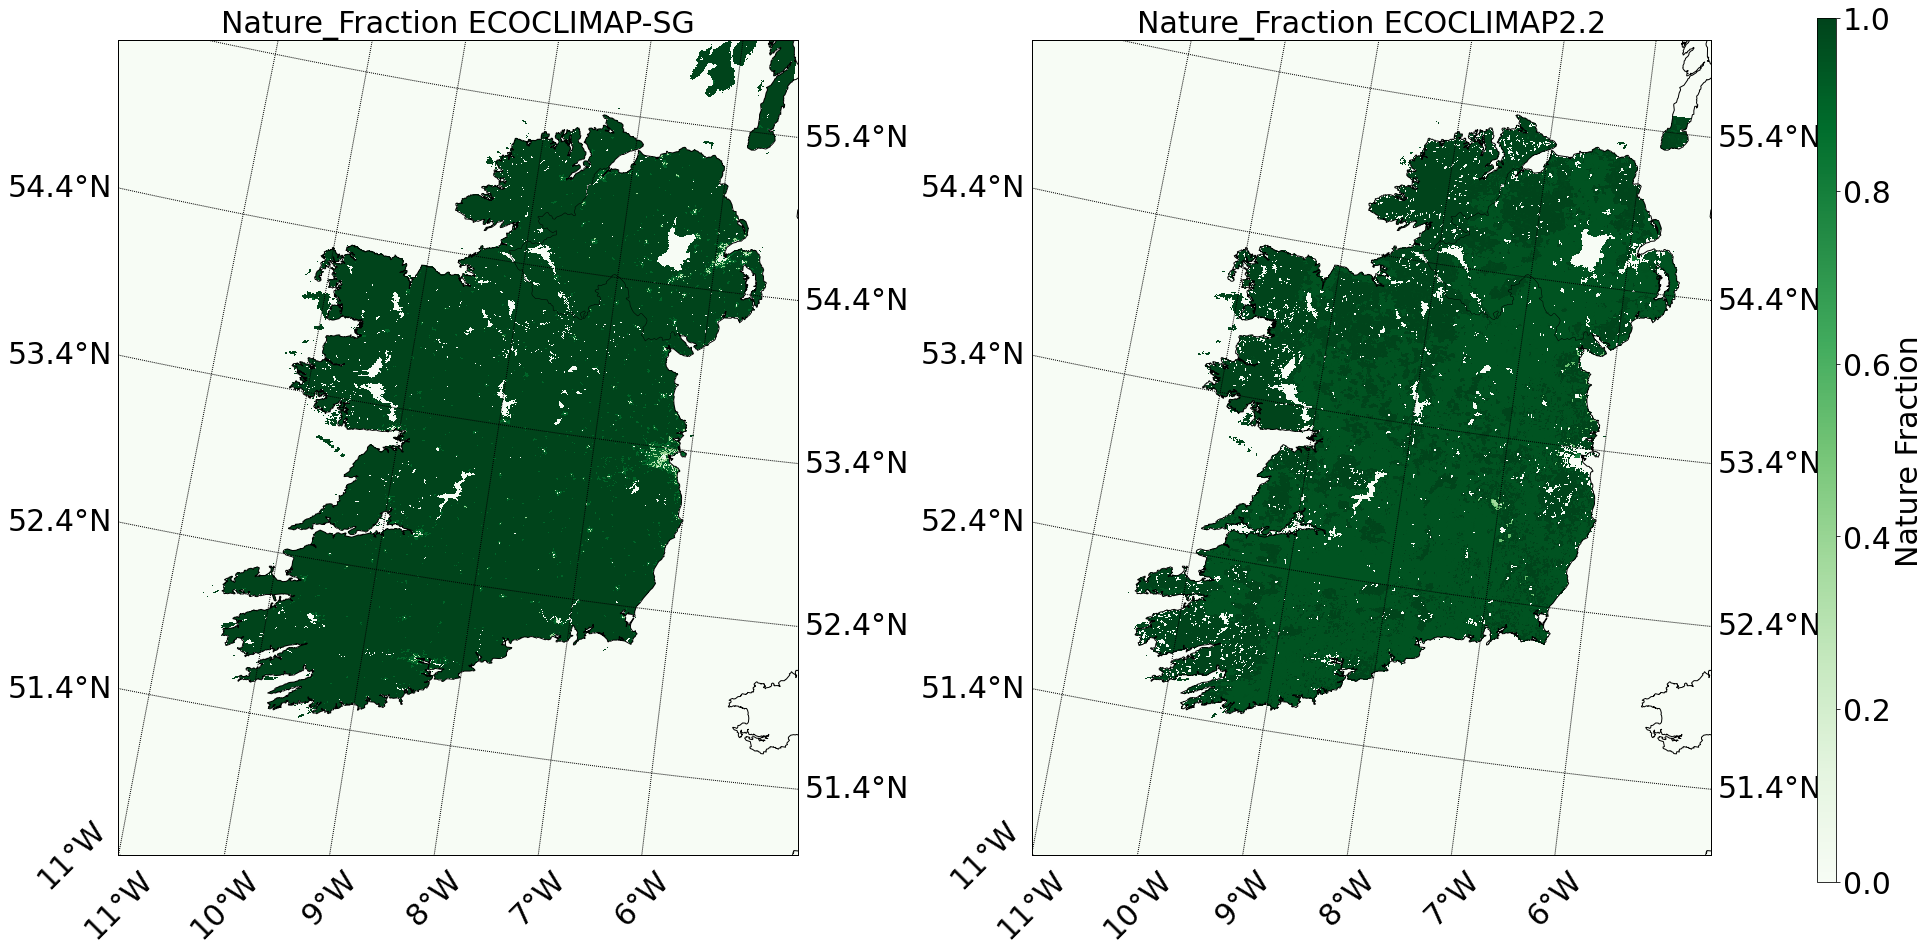

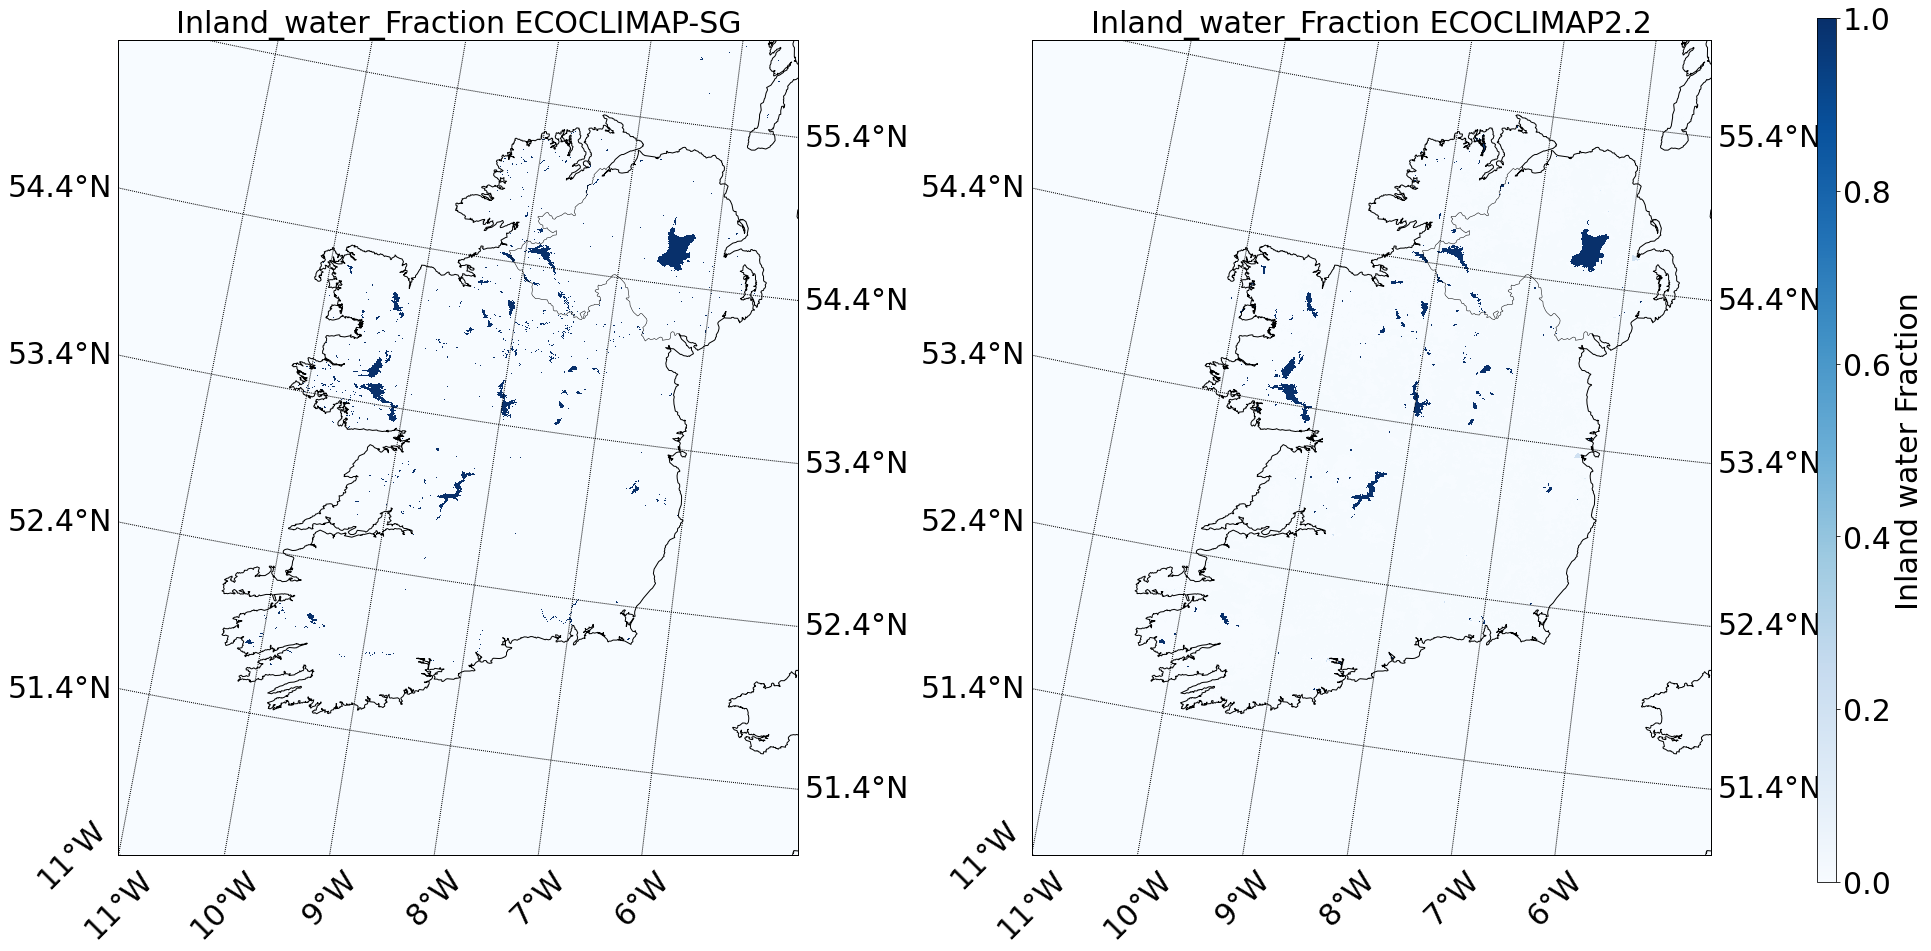

In [97]:
cmap = plt.cm.get_cmap('Greens')
rgba = cmap(0)
plot_ecosg_eco2_fraction(VegfracSG,LONSG,LATSG,VegfracII,LONII,LATII,colormap='Greens',LEG='Nature Fraction',vname='Nature_Fraction',fill=rgba)
cmap = plt.cm.get_cmap('Blues')
rgba = cmap(0)
plot_ecosg_eco2_fraction(InwfracSG,LONSG,LATSG,InwfracII,LONII,LATII,colormap='Blues',LEG='Inland water Fraction',vname='Inland_water_Fraction',fill=rgba)

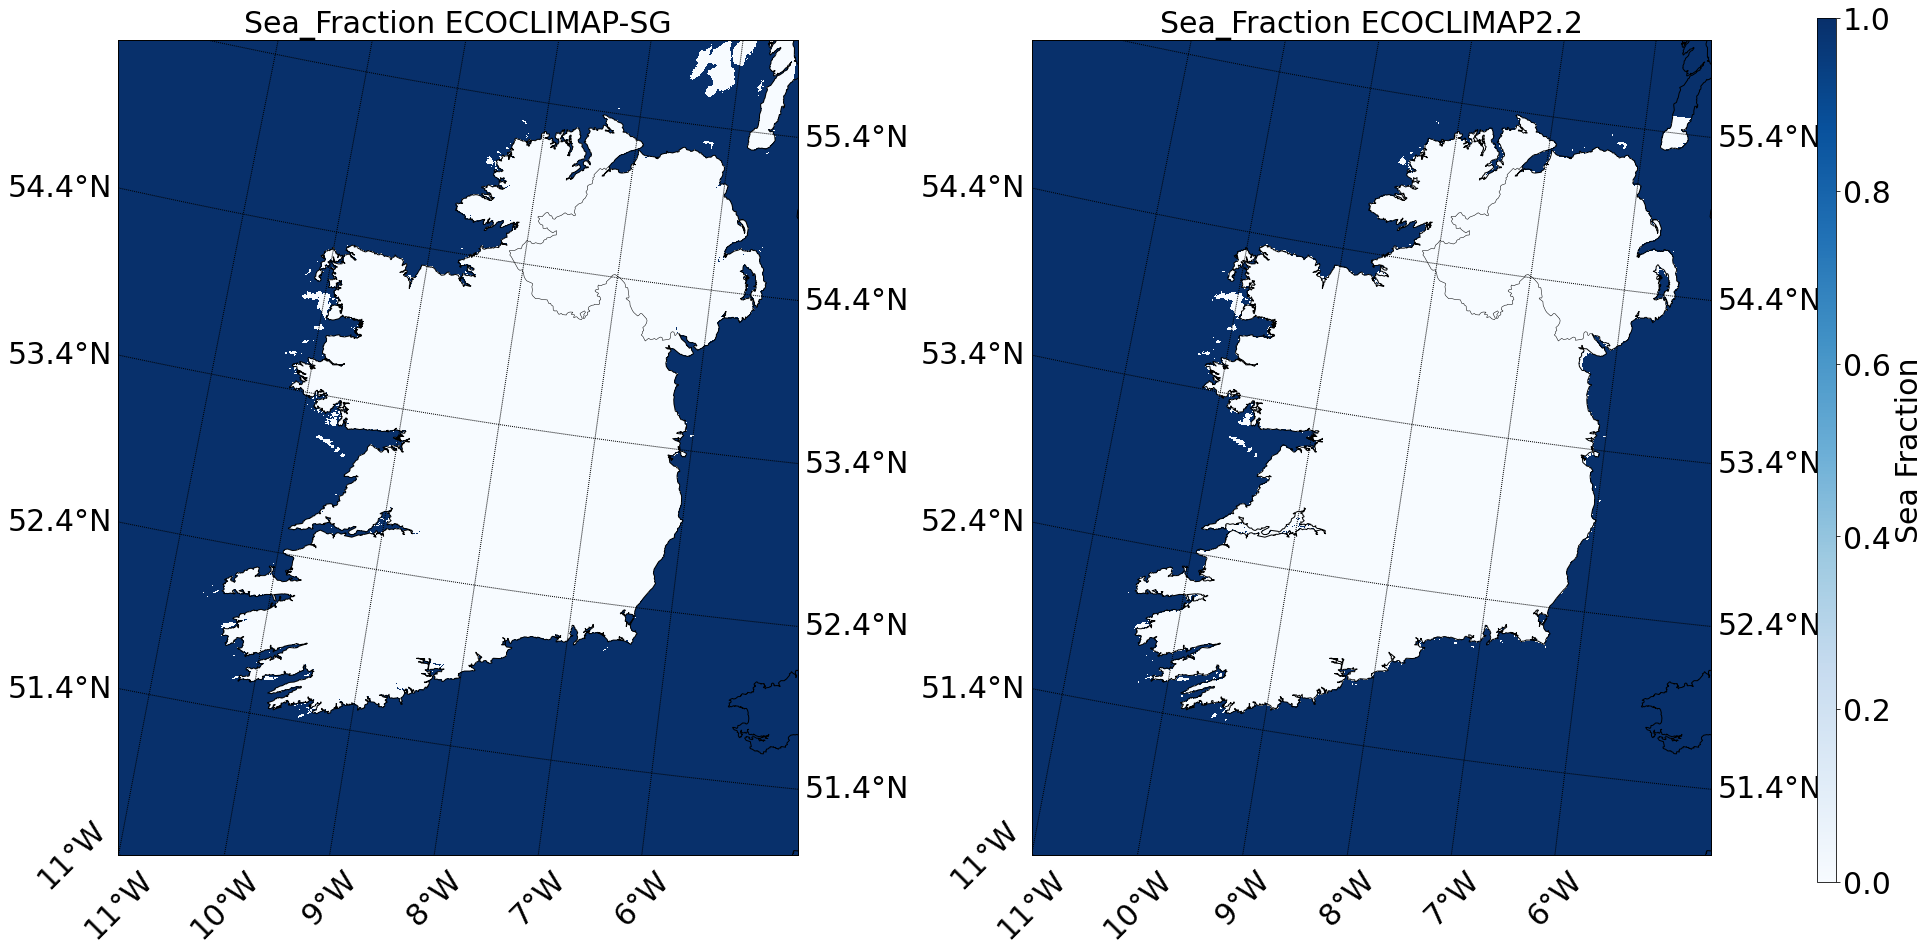

In [98]:
cmap = plt.cm.get_cmap('Blues')
rgba = cmap(259)
plot_ecosg_eco2_fraction(SeafracSG,LONSG,LATSG,SeafracII,LONII,LATII,colormap='Blues',LEG='Sea Fraction',vname='Sea_Fraction',fill=rgba)

In [ ]:
#Airports or station
plot_ecosg_eco2_fraction(TownfracSG,LONSG,LATSG,TownfracII,LONII,LATII,latc=LAT,lonc=LON,extent=0.05,
                         stationno=AIRPORT,LEG='Town Fraction',vname='Town_Fraction')
plot_ecosg_eco2_fraction(VegfracSG,LONSG,LATSG,VegfracII,LONII,LATII,latc=LAT,lonc=LON,extent=0.05,
                         stationno=AIRPORT,LEG='Nature Fraction',vname='Nature_Fraction')
plot_ecosg_eco2_fraction(InwfracSG,LONSG,LATSG,InwfracII,LONII,LATII,latc=LAT,lonc=LON,extent=0.05,
                         stationno=AIRPORT,LEG='Inland water Fraction',vname='Inland_water_Fraction')
plot_ecosg_eco2_fraction(SeafracSG,LONSG,LATSG,SeafracII,LONII,LATII,latc=LAT,lonc=LON,extent=0.05,
                         stationno=AIRPORT,LEG='Sea Fraction',vname='Sea_Fraction')


plot_ecosg_eco2_fraction(TownfracSG,LONSG,LATSG,TownfracII,LONII,LATII,latc=Stlat,lonc=Stlon,extent=0.05,
                         stationno=Stno,LEG='Town Fraction',vname='Town_Fraction')
plot_ecosg_eco2_fraction(VegfracSG,LONSG,LATSG,VegfracII,LONII,LATII,latc=Stlat,lonc=Stlon,extent=0.05,
                         stationno=Stno,LEG='Nature Fraction',vname='Nature_Fraction')
plot_ecosg_eco2_fraction(InwfracSG,LONSG,LATSG,InwfracII,LONII,LATII,latc=Stlat,lonc=Stlon,extent=0.05,
                         stationno=Stno,LEG='Inland water Fraction',vname='Inland_water_Fraction')
plot_ecosg_eco2_fraction(SeafracSG,LONSG,LATSG,SeafracII,LONII,LATII,latc=Stlat,lonc=Stlon,extent=0.05,
                         stationno=Stno,LEG='Sea Fraction',vname='Sea_Fraction')


